# Examples
Before doing anything you must import the library.

In [1]:
import shapefile

## Reading Shapefiles
###  The Reader Class
To read a shapefile create a new "Reader" object and pass it the name of an existing shapefile. The shapefile format is actually a collection of three files. You specify the base filename of the shapefile or the complete filename of any of the shapefile component files.

In [2]:
shape_file = "Data/Shape_NYC/taxi_zones.shp"
sf = shapefile.Reader(shape_file)

### Reading Shapefiles Using the Context Manager
The "Reader" class can be used as a context manager, to ensure open file objects are properly closed when done reading the data:



In [3]:
with shapefile.Reader(shape_file) as shp:
    print(shp)

shapefile Reader
    263 shapes (type 'POLYGON')
    263 records (7 fields)


## Reading Shapefile Meta-Data
Shapefiles have a number of attributes for inspecting the file contents. A shapefile is a container for a specific type of geometry, and this can be checked using the shapeType attribute.

Shape types are represented by numbers between 0 and 31 as defined by the shapefile specification and listed below. It is important to note that the numbering system has several reserved numbers that have not been used yet, therefore the numbers of the existing shape types are not sequential:

- NULL = 0
- POINT = 1
- POLYLINE = 3
- POLYGON = 5
- MULTIPOINT = 8
- POINTZ = 11
- POLYLINEZ = 13
- POLYGONZ = 15
- MULTIPOINTZ = 18
- POINTM = 21
- POLYLINEM = 23
- POLYGONM = 25
- MULTIPOINTM = 28
- MULTIPATCH = 31

Based on this we can see that our blockgroups shapefile contains Polygon type shapes. The shape types are also defined as constants in the shapefile module, so that we can compare types more intuitively:

In [4]:
sf.shapeType, sf.shapeType == shapefile.POLYGON, sf.shapeTypeName == 'POLYGON'

(5, True, True)

In [5]:
len(sf), sf.bbox

(263,
 [913175.109008804, 120121.88125434518, 1067382.508405164, 272844.2940054685])

Finally, if you would prefer to work with the entire shapefile in a different format, you can convert all of it to a GeoJSON dictionary, although you may lose some information in the process, such as z- and m-values:

In [6]:
sf.__geo_interface__['type']

'FeatureCollection'

## Reading Geometry
A shapefile's geometry is the collection of points or shapes made from vertices and implied arcs representing physical locations. All types of shapefiles just store points. The metadata about the points determine how they are handled by software.

You can get a list of the shapefile's geometry by calling the shapes() method.

In [7]:
shapes = sf.shapes()

In [8]:
len(shapes)

263

In [9]:
s = sf.shape(7)
['%.3f' % coord for coord in s.bbox]

['1004114.386', '221499.117', '1006968.780', '224422.048']

Each shape record (except Points) contains the following attributes. Records of shapeType Point do not have a bounding box 'bbox'.

In [10]:
for name in dir(shapes[3]):
    if not name.startswith('_'):
        print(name)

bbox
parts
points
shapeType
shapeTypeName


In [11]:
shapes[3].shapeType, shapes[3].shapeTypeName

(5, 'POLYGON')

In [17]:
bbox = shapes[3].bbox
['%.3f' % coord for coord in bbox]

['988733.885', '201170.618', '992114.154', '205029.463']

In [21]:
shapes[3].parts,  len(shapes[3].points)

([0], 88)

In [22]:
shape = shapes[3].points[7]
['%.3f' % coord for coord in shape]

['992029.295', '203479.072']

In most cases, however, if you need to do more than just type or bounds checking, you may want to convert the geometry to the more human-readable GeoJSON format, where lines and polygons are grouped for you:

In [24]:
s = sf.shape(0)
geoj = s.__geo_interface__
geoj["type"]
shapes.__geo_interface__['type']

'GeometryCollection'

## Reading Records
A record in a shapefile contains the attributes for each shape in the collection of geometries. Records are stored in the dbf file. The link between geometry and attributes is the foundation of all geographic information systems. This critical link is implied by the order of shapes and corresponding records in the shp geometry file and the dbf attribute file.


The field names of a shapefile are available as soon as you read a shapefile. You can call the "fields" attribute of the shapefile as a Python list. Each field is a Python list with the following information:

- Field name: the name describing the data at this column index.
- Field type: the type of data at this column index. Types can be:
    - "C": Characters, text.
    - "N": Numbers, with or without decimals.
    - "F": Floats (same as "N").
    - "L": Logical, for boolean True/False values.
    - "D": Dates.
    - "M": Memo, has no meaning within a GIS and is part of the xbase spec instead.
- Field length: the length of the data found at this column index. Older GIS software may truncate this length to 8 or 11 characters for "Character" fields.
- Decimal length: the number of decimal places found in "Number" fields.

To see the fields for the Reader object above (sf) call the "fields" attribute:

In [26]:
fields = sf.fields
fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

In [12]:
import pandas as pd
import numpy as np
# sf = shapefile.Reader("../data/raw/shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.023971e+06,266866.032718
259,260,0.133514,0.000422,Woodside,260,Queens,1.010063e+06,211298.529136
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.807446e+05,197628.272456
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.994435e+05,222247.381595


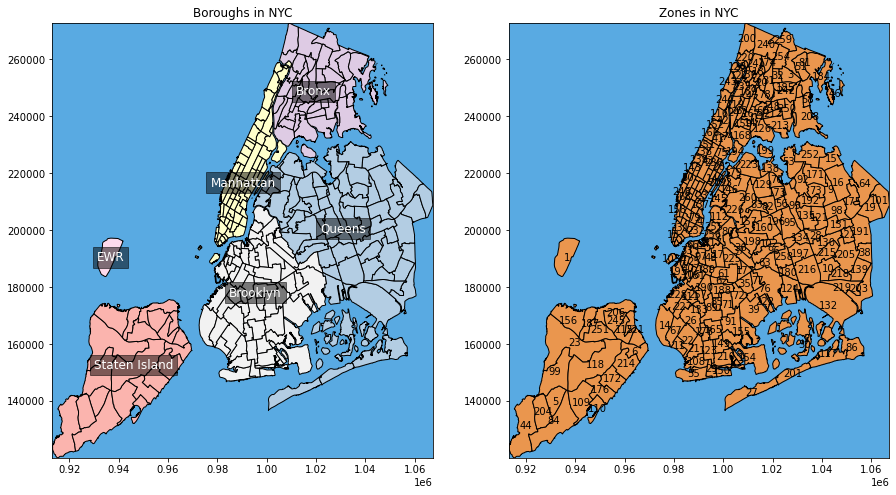

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin
    return lat_min, lat_max, lon_min, lon_max

def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)